# Nic/Malay Meeting

Stanford Python imports

In [1]:
import numpy as np
import sys
sys.path.append("../dwaveutils/dwavetools")
sys.path.append("../dwaveutils/probrep")
from dictrep import DictRep
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
import seaborn as sns
from dwavetools import (make_numeric_schedule)

### Generate random Ising Hamiltonain's of size 2, 3, 4, and 5 qubits

In [2]:
# set up the randomization and create the matrices
def rand_ising(n, seed=None):
    """
    Generates a random Ising Hamiltonian with h in (-1, 1) and 
    J in (-2, 2) represented as a dictionary.
    
    Input 
    ----------------------------------------------------------
    n: integer number of qubits desired
    seed: optional randomization seed for debugging/ testing
    
    Output
    ----------------------------------------------------------
    H = {(0, 0) h0, (1, 1): h1, (0, 1): J01, ...}
    """
    H = {}
    if seed:
        np.random.seed(seed)
    for i in range(n):
        H[(i, i)] = (2*np.random.random())-1
        for j in range(n):
            if j < i:
                H[(j, i)] = (4*np.random.random())-2
                
    return H

dictH2 = rand_ising(2, 1)
dictH3 = rand_ising(3, 2)
dictH4 = rand_ising(4, 3)
dictH5 = rand_ising(5, 4)
dictHs = [dictH2, dictH3, dictH4, dictH5]

In [3]:
# save the random Ising Hs to file
for (n, dictH) in enumerate(dictHs):
    fname = "H{}dict.txt".format(n+2)
    with open(fname, 'w') as file:
        for key, value in dictH.items():
            file.write(str(key) + " " + str(value) + "\n")

### This next part is just to turn it into a dictrep object which I use to perform numerical anneals and whatnot. 

In [4]:
# turn these into "dictrep" Hamiltonians
H2 = DictRep(dictH2, 'numerical', 'ising', 'logical')
H3 = DictRep(dictH3, 'numerical', 'ising', 'logical')
H4 = DictRep(dictH4, 'numerical', 'ising', 'logical')
H5 = DictRep(dictH5, 'numerical', 'ising', 'logical')
print(H2.H)
print("\n")
print(H3.H)
print("\n")
print(H4.H)
print("\n")
print(H5.H)

{(0, 0): -0.165955990594852, (1, 1): 0.4406489868843162, (0, 1): -1.9995425007306205}


{(0, 0): -0.12801019571599248, (1, 1): -0.9481475363442173, (0, 1): 0.19864991151483657, (2, 2): -0.12935521476344625, (0, 2): -0.3185287916500439, (1, 2): -0.6786607159845035}


{(0, 0): 0.10159580514915101, (1, 1): 0.41629564523620965, (0, 1): -0.8363810443482227, (2, 2): 0.02165521039532603, (0, 2): 1.5717878173906188, (1, 2): 1.5851723557337523, (3, 3): -0.7488293790723275, (0, 3): -1.171028487447253, (1, 3): -1.7941311867966805, (2, 3): -0.23676062539745413}


{(0, 0): 0.9340596780273533, (1, 1): 0.09446449835144466, (0, 1): 1.8907374398595373, (2, 2): 0.4296319873487293, (0, 2): 0.7909152983890833, (1, 2): -1.1356420176784945, (3, 3): 0.9525489095524835, (0, 3): -1.9750789791816405, (1, 3): -0.9880705504662242, (2, 3): -0.26083387038221684, (4, 4): 0.5587658435875049, (0, 4): -1.2092597015989877, (1, 4): 1.451972942396889, (2, 4): 1.933602708701251, (3, 4): -1.3446310343812051}


### Perform Direct Diagonliation
Since these are randomly generated Ising problems with only $\sigma_z$ terms, then it is likely that that there are no degenerate energies. Hence, these all have a single ground-state that is NOT a superposition in the computation (z basis). As such, these ground-states are just a long list of mostly 0's and a single 1 corresponding to the gs. To make it easier to read, I just found the placement of this 1. I.e. for the H3 Hamiltonian as defined, the ground-state happens to be $|0> \otimes |0> \otimes |0>$, which corresponds to the $|0>$ state in the 3-qubit Hilbert space, so the first nonzero element is 0. 

Similarly, the first non-zero (and therefore only one) in the H5 ground-state is 19. 

WARNING: THESE USE 0 BASED NUMBERING.

In [5]:
# perform direct diagonlization and print the index of the ground-state
# (we can do this because there will (most likely) be a singular state with randomly generated Hz
H2diag = H2.diag_H()
H3diag = H3.diag_H()
H4diag = H4.diag_H()
H5diag = H5.diag_H()
Hdiags = [H2diag, H3diag, H4diag, H5diag]
firstnonzero = [0, 0, 0, 0]
for (idx1, Hdiag) in enumerate(Hdiags):
    for (idx2, ele) in enumerate(Hdiag):
        if ele == 1:
            firstnonzero[idx1] = idx2
print(firstnonzero)

[3, 0, 2, 19]


### Perform Forward Anneal Until G-S is well approximated
For these, I use my numerical forward anneal protocol to find the ground-state of H. In particular, I print the state-vector I find, the "print(amps)" statement, and I plot the discrete probability distribution function that follows (the bar plot below it).

By "until G-S is well approximated," I mean (using your own protocal) find an annealing length (in your own time units) that is long enough such that the ground-state obtained with this method is very close to the ground-state obtained by direct diagonlization. For example, for H2, the output should be a bar in the '3' position and there should be no appreciate probability of getting any other state. In my case, this took a forward annealing length of T2 = 18. 

NOTE: TRY TO FIND THE LOWEST TIME FOR WHICH YOU GET A GOOD APPROXIMATION, NOW JUST ONE THAT WORKS

[3.03895177e-02 1.04781550e-08 2.10228609e-08 9.69610451e-01]


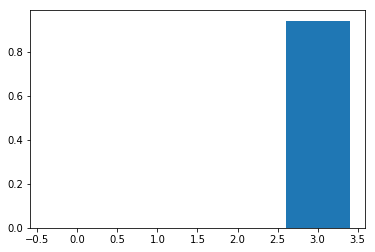

In [62]:
# H2
disc2, T2 = .1, 18
sch2 = make_numeric_schedule(disc2, **{'ta': T2})
amps = H2.nf_anneal(sch2)
print(amps.flatten())
probs = np.array([abs(amps[i])**2 for i in range(4)])
plt.bar([i for i in range(4)], probs.flatten())
plt.show()

[9.99717429e-01 7.03125019e-08 1.59435732e-08 4.28455927e-09
 2.81018635e-04 1.45236117e-06 1.21160595e-10 9.18704289e-09]


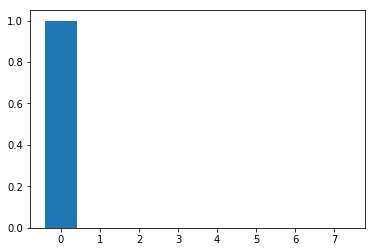

In [65]:
# H3
disc3, T3 = .1, 18
sch3 = make_numeric_schedule(disc3, **{'ta': T3})
amps = H3.nf_anneal(sch3)
print(amps.flatten())
probs = np.array([abs(amps[i])**2 for i in range(2**3)])
plt.bar([i for i in range(2**3)], probs.flatten())
plt.show()

[2.36288648e-08 8.92976426e-14 9.27315620e-01 3.35000378e-10
 2.57761919e-10 5.52768533e-10 4.00397899e-10 8.14151733e-10
 1.30129737e-08 1.69843618e-11 1.93285819e-09 2.70644705e-09
 9.70962805e-09 7.26843043e-02 1.09881332e-11 2.21766771e-08]


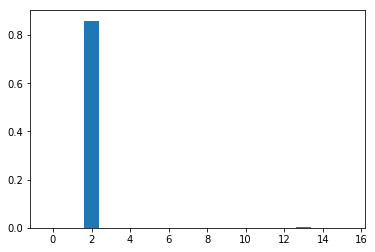

In [66]:
# H4
disc4, T4 = .1, 50
sch4 = make_numeric_schedule(disc4, **{'ta': T4})
amps = H4.nf_anneal(sch4)
print(amps.flatten())
probs = np.array([abs(amps[i])**2 for i in range(2**4)])
plt.bar([i for i in range(2**4)], probs.flatten())
plt.show()

[5.18010676e-12 1.36448574e-10 8.67459923e-14 3.74606066e-10
 8.01531727e-09 6.86308548e-14 2.04329423e-13 2.16940817e-13
 6.82220134e-11 7.39192669e-12 4.44297664e-15 1.46305628e-10
 8.97786357e-06 1.78865083e-10 3.98143851e-08 8.35500691e-11
 1.09992421e-09 2.91907874e-08 4.03539081e-10 9.99990901e-01
 6.43032592e-10 1.85897309e-09 4.82312483e-10 1.52072858e-08
 4.38058658e-14 7.31918492e-13 2.93108334e-10 1.21499966e-08
 6.73686741e-10 7.89048734e-14 1.27402703e-09 9.42301847e-09]


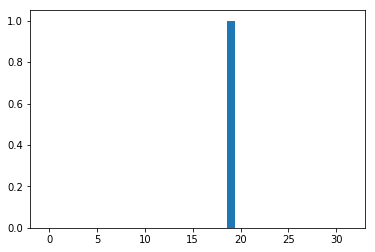

In [67]:
# H5 
disc5, T5 = .1, 50
sch5 = make_numeric_schedule(disc5, **{'ta':T5})
amps = H5.nf_anneal(sch5)
print(amps.flatten())
probs = np.array([abs(amps[i])**2 for i in range(2**5)])
plt.bar([i for i in range(2**5)], probs.flatten())
plt.show()

### Now perform the anneal with 1/10 of the time to see how state-distribution changes
The idea is that, regardless of the method you use to anneal, if you find a time that works and then use 1/10 of this time, the distribution of states should be a worse approximation to the actual ground-state. 

Given that your method is different (not using the D-wave schedule), we should not expect that our outputs should be exactly the same. In particular, it is very hard to guess which states should become to be populated. One test that would be good to do on your end, for example, is to do an anneal for a very, very short time. Ideally, this should give you a ground-state that well approximates the ground-state of your initial Hamiltonian. 

You can find this with your diagonlization routine with your Hi, for example. 

[0.43659408 0.01035347 0.00166864 0.55138381]


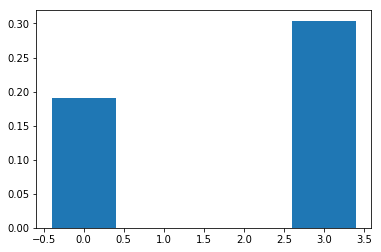

In [68]:
# H2
disc2, T2 = .1, 18/10
sch2 = make_numeric_schedule(disc2, **{'ta': T2})
amps = H2.nf_anneal(sch2)
print(amps.flatten())
probs = np.array([abs(amps[i])**2 for i in range(4)])
plt.bar([i for i in range(4)], probs.flatten())
plt.show()

[0.42656194 0.0476984  0.01736655 0.06825431 0.25251875 0.14089992
 0.00157192 0.04512821]


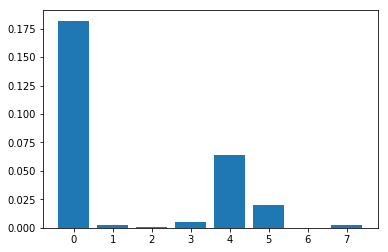

In [69]:
# H3
disc3, T3 = .1, 18/10
sch3 = make_numeric_schedule(disc3, **{'ta': T3})
amps = H3.nf_anneal(sch3)
print(amps.flatten())
probs = np.array([abs(amps[i])**2 for i in range(2**3)])
plt.bar([i for i in range(2**3)], probs.flatten())
plt.show()

[1.38660189e-03 3.46653587e-10 5.25144705e-01 2.21308427e-04
 1.14237666e-04 8.41095165e-06 3.33778683e-05 1.47953184e-04
 8.10612226e-05 1.02236881e-07 4.55443189e-06 2.67598117e-08
 9.58155554e-03 4.62364098e-01 2.33992442e-08 9.11982888e-04]


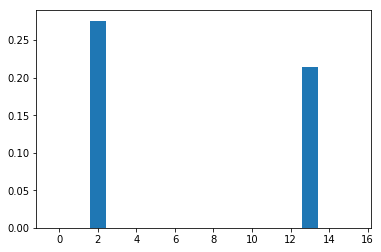

In [70]:
# H4
disc4, T4 = .1, 50/10
sch4 = make_numeric_schedule(disc4, **{'ta': T4})
amps = H4.nf_anneal(sch4)
print(amps.flatten())
probs = np.array([abs(amps[i])**2 for i in range(2**4)])
plt.bar([i for i in range(2**4)], probs.flatten())
plt.show()

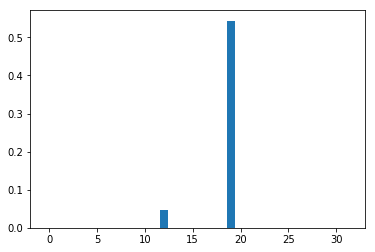

In [58]:
# H5 
disc5, T5 = .1, 50/10
sch5 = make_numeric_schedule(disc5, **{'ta':T5})
amps = H5.nf_anneal(sch5)
probs = np.array([abs(amps[i])**2 for i in range(2**5)])
plt.bar([i for i in range(2**5)], probs.flatten())
plt.show()